<a href="https://colab.research.google.com/github/mdsalem17/scientific-guide-notebooks/blob/main/MNIST_GANs/MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional GAN (DCGAN)

## Introduction
In this notebook, we're going to implement a Deep Convolutional GAN (DCGAN) using the MNIST dataset.


![Generator architecture](http://salem.scientific-guide.com/wp-content/uploads/2021/11/dcgan-gen.png)

Figure: Architectural drawing of a generator from DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

## Getting Started

### DCGAN
Here are the main features of DCGAN: 

<!-- ```
Architecture guidelines for stable Deep Convolutional GANs
• Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
• Use BatchNorm in both the generator and the discriminator.
• Remove fully connected hidden layers for deeper architectures.
• Use ReLU activation in generator for all layers except for the output, which uses Tanh.
• Use LeakyReLU activation in the discriminator for all layers.
``` -->


*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## Generator
The first component we will make is the generator. We may notice that instead of passing in the image dimension, we will pass the number of image channels to the generator. This is because with DCGAN, we use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

We will build a generator using 4 layers (3 hidden layers + 1 output layer). 

Since in DCGAN the activation function will be different for the output layer, we will need to check what layer is being created.

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        #     Steps:
        #       1) Do a transposed convolution using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a ReLU activation.
        #       4) If its the final layer, use a Tanh activation after the deconvolution.

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [3]:
'''
Testing make_gen_block() function
'''
gen = Generator()
num_test = 100

# Test the hidden block
test_hidden_noise = get_noise(num_test, gen.z_dim)
test_hidden_block = gen.make_gen_block(10, 20, kernel_size=4, stride=1)
test_uns_noise = gen.unsqueeze_noise(test_hidden_noise)
hidden_output = test_hidden_block(test_uns_noise)

# Check that it works with other strides
test_hidden_block_stride = gen.make_gen_block(20, 20, kernel_size=4, stride=2)

test_final_noise = get_noise(num_test, gen.z_dim) * 20
test_final_block = gen.make_gen_block(10, 20, final_layer=True)
test_final_uns_noise = gen.unsqueeze_noise(test_final_noise)
final_output = test_final_block(test_final_uns_noise)

# Test the whole thing:
test_gen_noise = get_noise(num_test, gen.z_dim)
test_uns_gen_noise = gen.unsqueeze_noise(test_gen_noise)
gen_output = gen(test_uns_gen_noise)

Here's the test for our generator block:

In [4]:
# UNIT TESTS
assert tuple(hidden_output.shape) == (num_test, 20, 4, 4)
assert hidden_output.max() > 1
assert hidden_output.min() == 0
assert hidden_output.std() > 0.2
assert hidden_output.std() < 1
assert hidden_output.std() > 0.5

assert tuple(test_hidden_block_stride(hidden_output).shape) == (num_test, 20, 10, 10)

assert final_output.max().item() == 1
assert final_output.min().item() == -1

assert tuple(gen_output.shape) == (num_test, 1, 28, 28)
assert gen_output.std() > 0.5
assert gen_output.std() < 0.8
print("Success!")

Success!


## Discriminator
The second component we need to create is the discriminator.

We will use 3 layers in our discriminator's neural network. Like with the generator, we will need create the function to create a single neural network block for the discriminator.

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is our default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        #     Steps:
        #       1) Add a convolutional layer using the given parameters.
        #       2) Do a batchnorm, except for the last layer.
        #       3) Follow each batchnorm with a LeakyReLU activation with slope 0.2.
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [6]:
'''
Testing make_disc_block() function
'''
num_test = 100

gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

# Test the hidden block
test_hidden_block = disc.make_disc_block(1, 5, kernel_size=6, stride=3)
hidden_output = test_hidden_block(test_images)

# Test the final block
test_final_block = disc.make_disc_block(1, 10, kernel_size=2, stride=5, final_layer=True)
final_output = test_final_block(test_images)

# Test the whole thing:
disc_output = disc(test_images)

Here's a test for our discriminator block:

In [7]:
# Test the hidden block
assert tuple(hidden_output.shape) == (num_test, 5, 8, 8)
# Because of the LeakyReLU slope
assert -hidden_output.min() / hidden_output.max() > 0.15
assert -hidden_output.min() / hidden_output.max() < 0.25
assert hidden_output.std() > 0.5
assert hidden_output.std() < 1

# Test the final block

assert tuple(final_output.shape) == (num_test, 10, 6, 6)
assert final_output.max() > 1.0
assert final_output.min() < -1.0
assert final_output.std() > 0.3
assert final_output.std() < 0.6

# Test the whole thing:

assert tuple(disc_output.shape) == (num_test, 1)
assert disc_output.std() > 0.25
assert disc_output.std() < 0.5
print("Success!")

Success!


## Training
Now we can put it all together!
These are our parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times we iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device type


In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Then, we can initialize our generator, discriminator, and optimizers.

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Finally, we can train our GAN!
For each epoch, we will process the entire dataset in batches. For every batch, we will update the discriminator and generator. Then, we can see DCGAN's results!

Here's roughly the progression we should be expecting. On GPU this takes about 30 seconds per thousand steps. We might notice that in the image of Step 5000, the generator is disproprotionately producing things that look like ones. If the discriminator didn't learn to detect this imbalance quickly enough, then the generator could just produce more ones. As a result, it may have ended up tricking the discriminator so well that there would be no more improvement, known as mode collapse: 
![MNIST Digits Progression](http://salem.scientific-guide.com/wp-content/uploads/2021/11/MNIST_DCGAN_Progression.png)


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.9719299814105036, discriminator loss: 0.5070190667212009


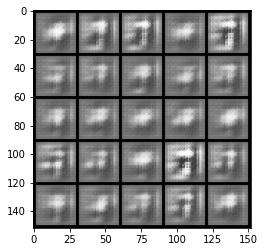

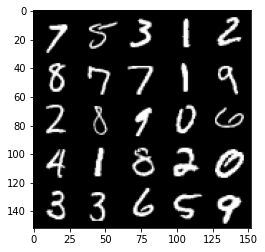

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.495148289859293, discriminator loss: 0.40872463110089324


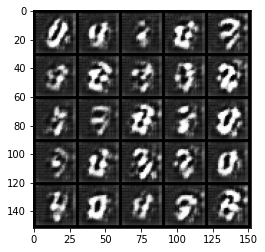

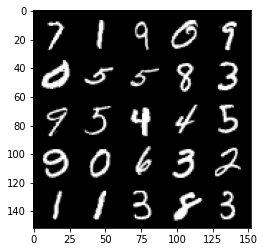

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.9661345898807052, discriminator loss: 0.5896227127909657


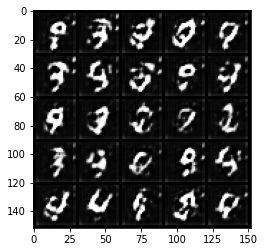

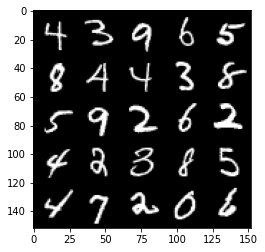

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.8635083485841748, discriminator loss: 0.6177321584224698


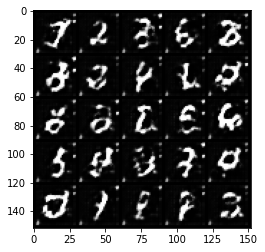

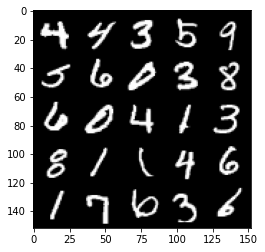

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.7964355187416082, discriminator loss: 0.6495123132467266


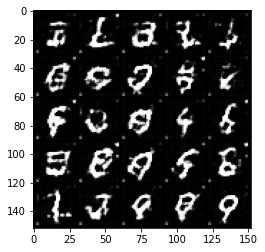

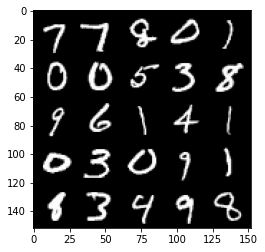

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.7776779021620749, discriminator loss: 0.6617645518779747


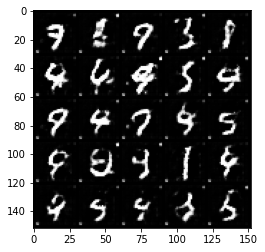

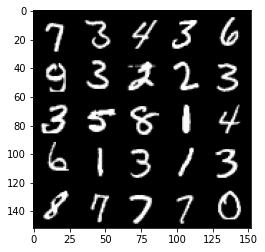

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.755077876269817, discriminator loss: 0.6716793420314789


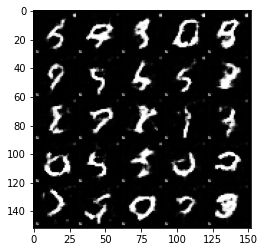

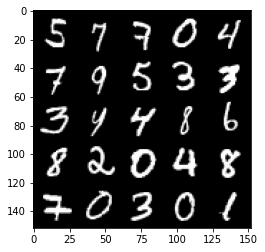

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.7478829499483111, discriminator loss: 0.6771388442516326


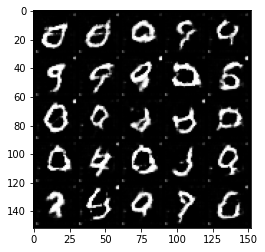

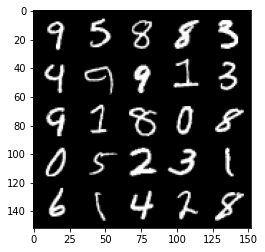

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.7478635182976733, discriminator loss: 0.6784178311824799


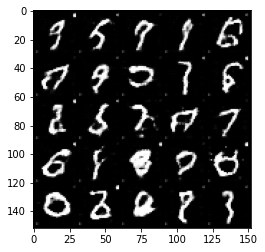

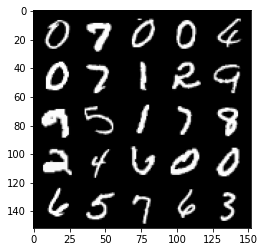

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.744184332787991, discriminator loss: 0.6768697967529296


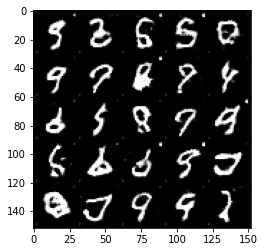

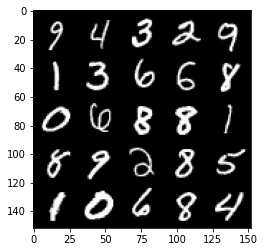

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7435699930787089, discriminator loss: 0.6777724261283878


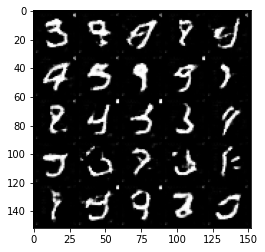

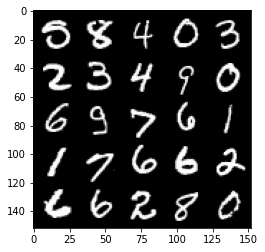

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7462498245835302, discriminator loss: 0.6795095311403269


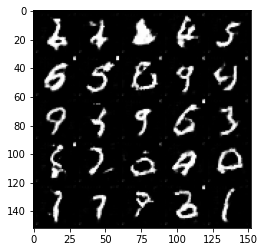

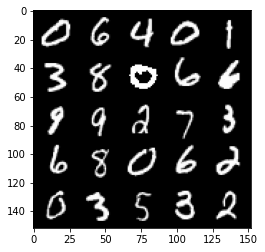

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7400331122279168, discriminator loss: 0.6804945545196526


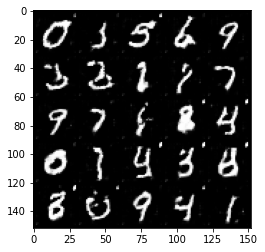

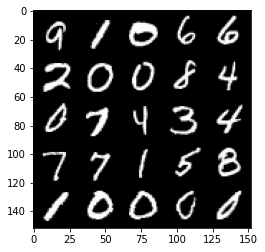

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7402497720718388, discriminator loss: 0.6804254385232924


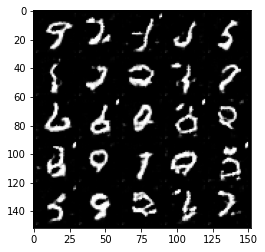

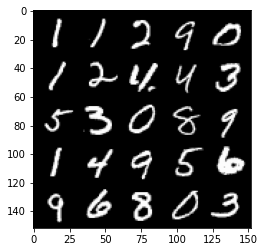

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7330209397077563, discriminator loss: 0.6816908427476877


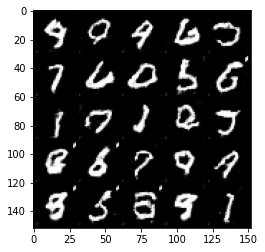

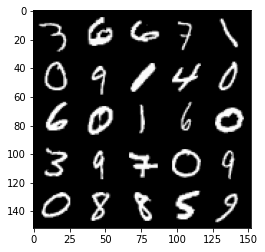

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7288446745872496, discriminator loss: 0.6839951241016383


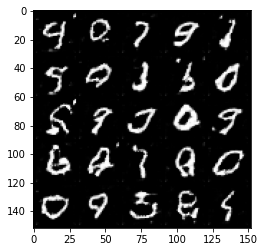

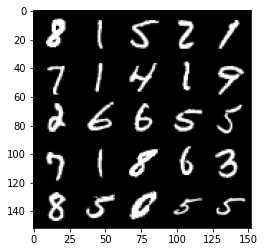

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7300003232359892, discriminator loss: 0.6856968150138854


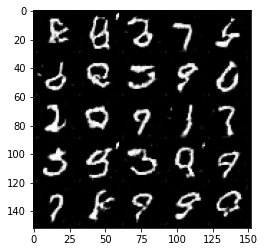

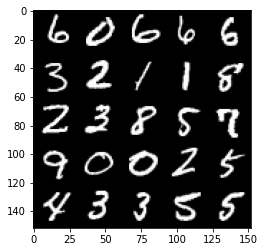

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.725975007295609, discriminator loss: 0.6867391577959059


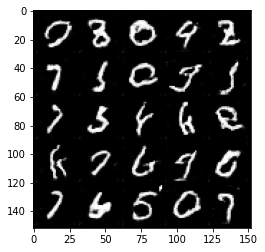

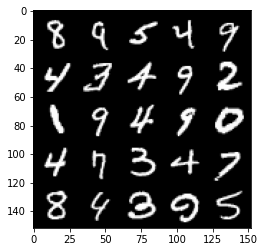

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7233429760336884, discriminator loss: 0.6878061077594756


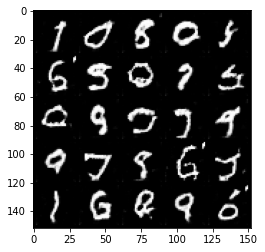

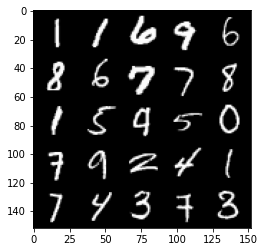

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7238793963193895, discriminator loss: 0.6911227538585669


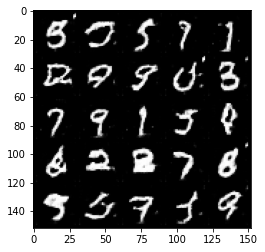

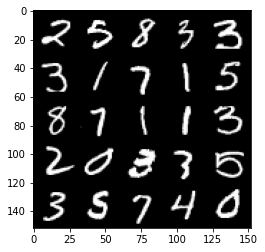

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7194913184642796, discriminator loss: 0.6905443054437634


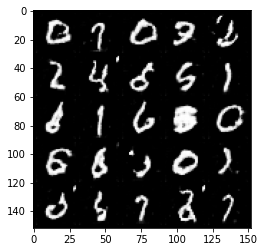

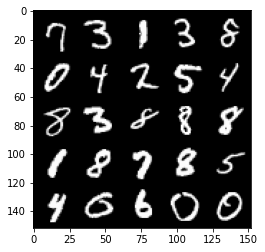

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7217099118828771, discriminator loss: 0.6909903446435928


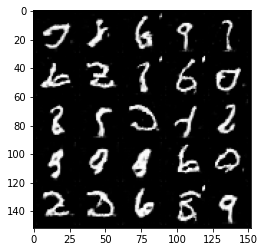

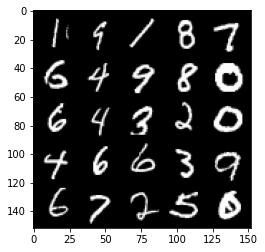

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7163165039420127, discriminator loss: 0.6906645179986951


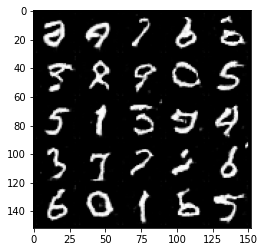

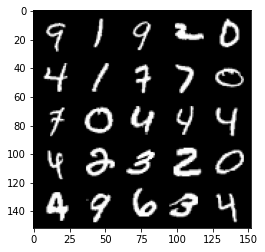

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7155426018834116, discriminator loss: 0.6920186600685122


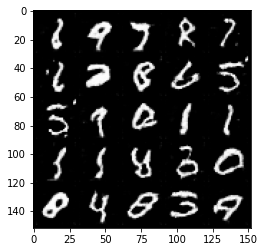

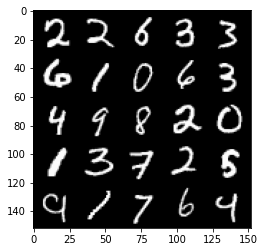

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7151064332723611, discriminator loss: 0.6917945121526721


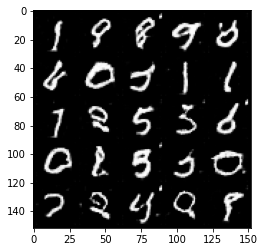

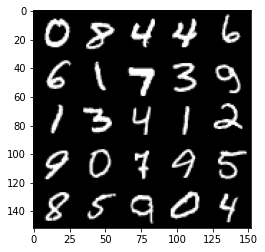

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7124101417064678, discriminator loss: 0.6928708339929587


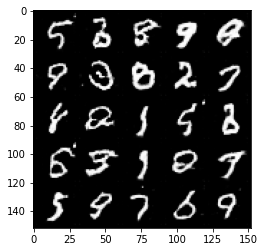

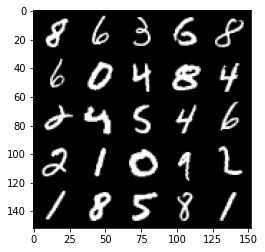

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7107004564404492, discriminator loss: 0.6941953923702242


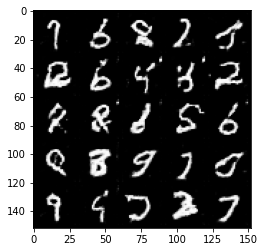

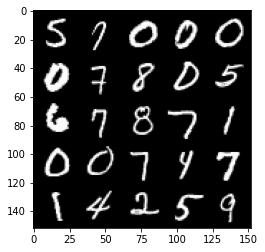

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7090158401131634, discriminator loss: 0.6934654514789583


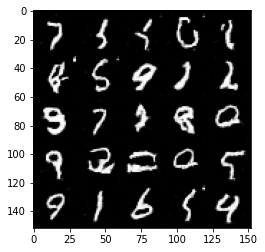

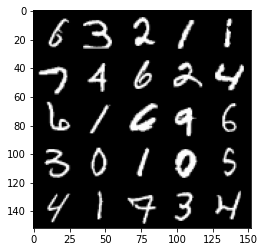

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.712384522855282, discriminator loss: 0.6932427306175231


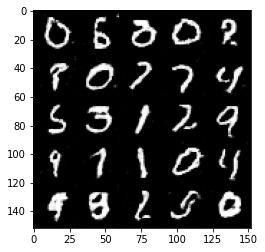

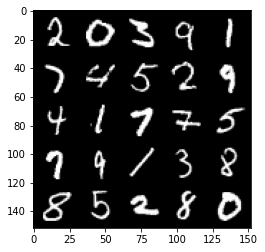

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.712391721367836, discriminator loss: 0.6932620679140089


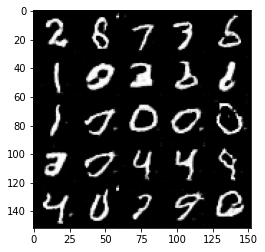

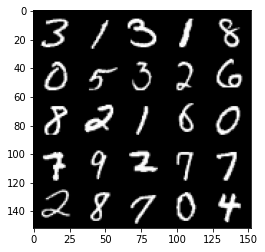

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7107790458202367, discriminator loss: 0.693314343571663


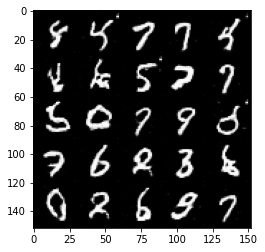

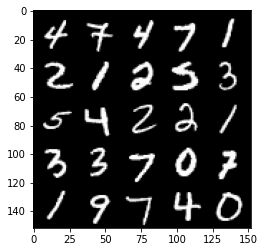

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6999481489062306, discriminator loss: 0.7031238811016092


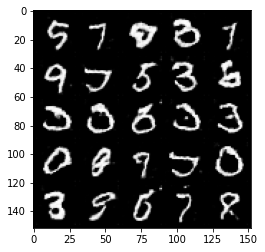

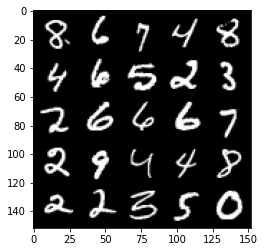

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7071265723705293, discriminator loss: 0.6950381525754931


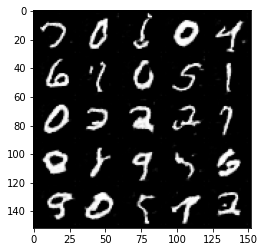

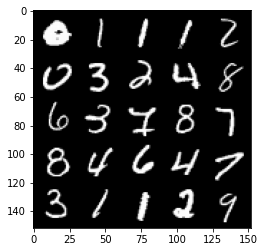

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7024796674251549, discriminator loss: 0.6973831037282937


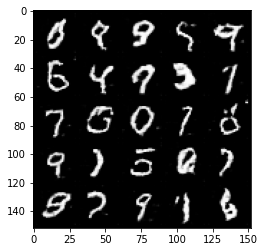

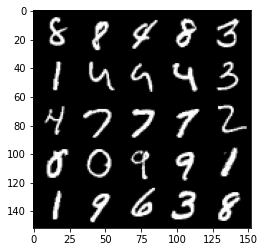

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7064418783187867, discriminator loss: 0.6937531962394714


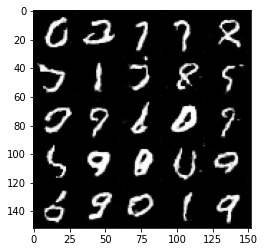

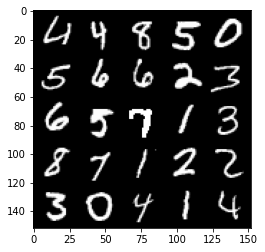

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7067630295753486, discriminator loss: 0.6938187232017522


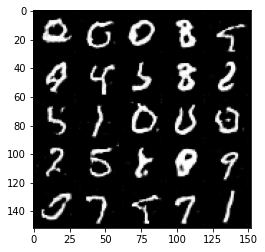

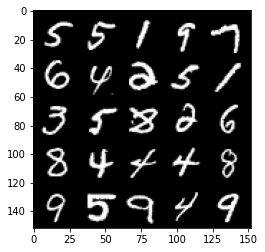

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7050901204347614, discriminator loss: 0.6946864076852798


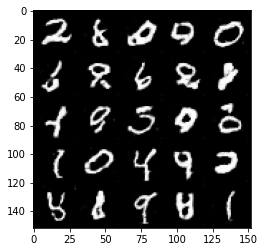

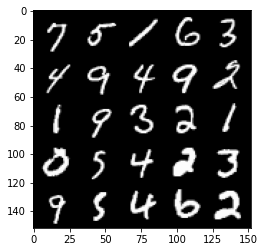

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.7042105488777158, discriminator loss: 0.6937292045354841


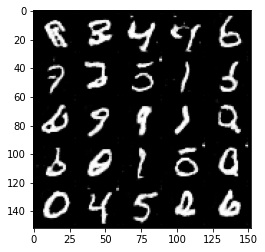

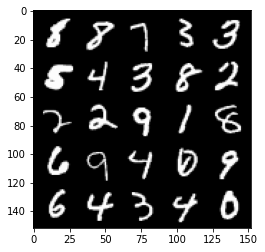

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.705724892497063, discriminator loss: 0.6931898019313809


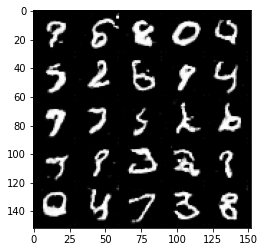

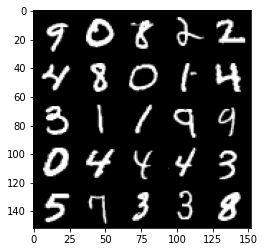

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7021426337957376, discriminator loss: 0.6935052460432053


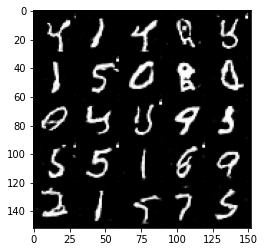

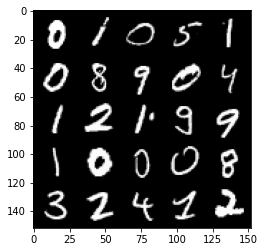

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.7040872349143026, discriminator loss: 0.6940517153739935


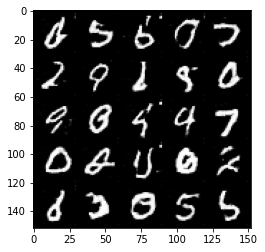

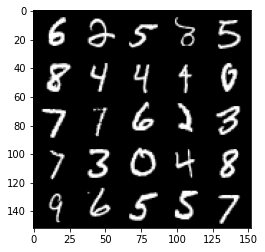

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.7020481528043754, discriminator loss: 0.6942652426958078


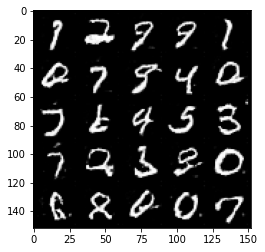

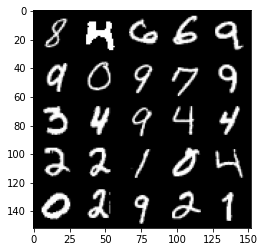

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.701600528776645, discriminator loss: 0.6940577487945561


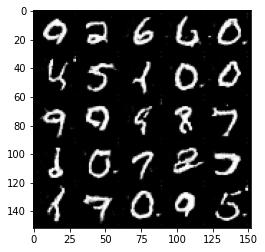

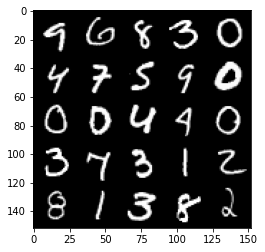

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.7014805054068565, discriminator loss: 0.6941318132877355


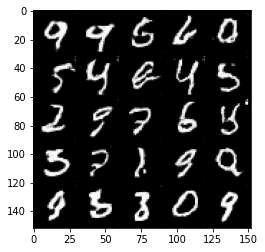

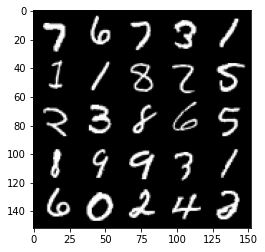

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.7022337478399282, discriminator loss: 0.6937277288436894


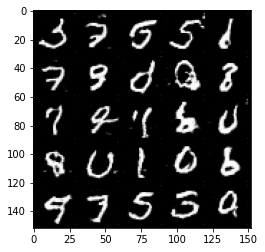

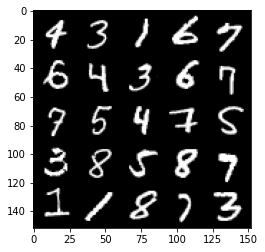

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.7008371298909188, discriminator loss: 0.6941142201423646


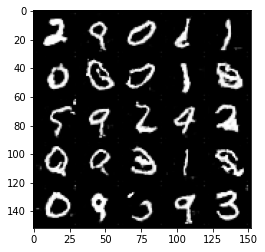

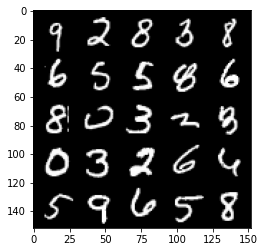

In [10]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


## Reference
1. Coursera. ‘Build Basic Generative Adversarial Networks (GANs)’. https://www.coursera.org/specializations/generative-adversarial-networks-gans.

2. Radford, Alec, Luke Metz, and Soumith Chintala. ‘Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks’. ArXiv:1511.06434 [Cs], 19 November 2015. http://arxiv.org/abs/1511.06434.